In [2]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import sys
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Using TensorFlow backend.


In [57]:
train = pd.read_csv("network-intrusion-detection/Train_data.csv")
test = pd.read_csv("network-intrusion-detection/Test_data.csv")

In [157]:
#print(train.head(4))

#print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))
train['flag'].iloc[2900] = 'REJ'
train.iloc[2900]



duration                             0
protocol_type                     icmp
service                        private
flag                               REJ
src_bytes                            0
dst_bytes                            0
land                                 0
wrong_fragment                       0
urgent                               0
hot                                  0
num_failed_logins                    0
logged_in                            0
num_compromised                      0
root_shell                           0
su_attempted                         0
num_root                             0
num_file_creations                   0
num_shells                           0
num_access_files                     0
num_outbound_cmds                    0
is_host_login                        0
is_guest_login                       0
count                              114
srv_count                           20
serror_rate                          1
srv_serror_rate          

In [158]:
print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp   private  REJ          0          0     0   
1         0           tcp   private  REJ          0          0     0   
2         2           tcp  ftp_data   SF      12983          0     0   
3         0          icmp     eco_i   SF         20          0     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          0                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0           0             0         0                   0           0   
1           0             0         0                   0           0   
2           0 

In [159]:
train.isnull().any().sum()
test.isnull().any().sum()
#train['protocol_type'].loc[0] = 'icmp'
#train['protocol_type'].loc[0]

0

In [140]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [141]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [142]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))
# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [143]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()
# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)
# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [144]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape
print(train_y[0])
print(train_x.loc[0])

normal
duration                       -0.113551
src_bytes                      -0.009889
dst_bytes                      -0.039310
land                           -0.008910
wrong_fragment                 -0.091223
urgent                         -0.006301
hot                            -0.091933
num_failed_logins              -0.026220
logged_in                      -0.807626
num_compromised                -0.021873
root_shell                     -0.039377
su_attempted                   -0.027665
num_root                       -0.021724
num_file_creations             -0.027808
num_shells                     -0.018905
num_access_files               -0.043917
num_outbound_cmds               0.000000
is_host_login                   0.000000
is_guest_login                 -0.095990
count                          -0.720244
srv_count                      -0.354628
serror_rate                    -0.640142
srv_serror_rate                -0.633978
rerror_rate                    -0.372186
srv_rerro

In [145]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 41)

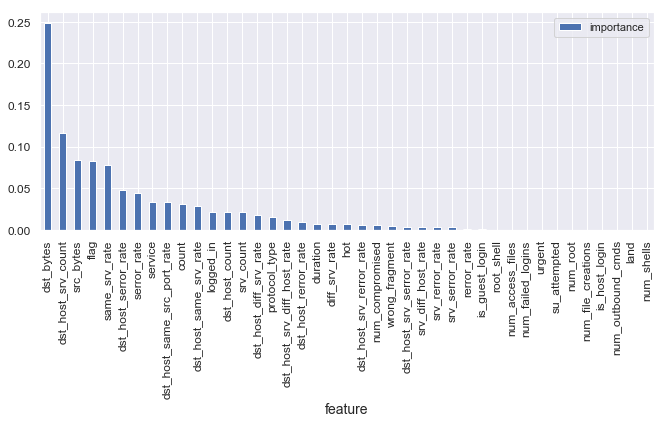

In [146]:
#feature Selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [147]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.izip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'hot',
 'count',
 'srv_count',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_serror_rate',
 'protocol_type',
 'service',
 'flag']

In [148]:
#dataset partition
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape
X_test.iloc[0]

duration                       -0.113551
src_bytes                      -0.010093
dst_bytes                      -0.039310
land                           -0.008910
wrong_fragment                 -0.091223
urgent                         -0.006301
hot                            -0.091933
num_failed_logins              -0.026220
logged_in                      -0.807626
num_compromised                -0.021873
root_shell                     -0.039377
su_attempted                   -0.027665
num_root                       -0.021724
num_file_creations             -0.027808
num_shells                     -0.018905
num_access_files               -0.043917
num_outbound_cmds               0.000000
is_host_login                   0.000000
is_guest_login                 -0.095990
count                           0.256462
srv_count                      -0.106238
serror_rate                     1.595477
srv_serror_rate                 1.600209
rerror_rate                    -0.372186
srv_rerror_rate 

In [149]:
#fitting models
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train);

#Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

#Train Gaussian Navie Bayes Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train,Y_train);

#Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DTC_Classifier.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [150]:
#evaluation
from sklearn import metrics

models=[]
models.append(('Naive Bayes Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
acc = []
cross_score = []

for i,v in models:
    scores = cross_val_score(v,X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train,v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train,v.predict(X_train))
    classification = metrics.classification_report(Y_train,v.predict(X_train))
    print('==========================={} Model Evaluation==============================='.format(i))
    print("Cross Validation Mean Score:", scores.mean())
    print("Model Accuracy:", accuracy)
    print("Classsification Report")
    print(classification)
    acc.append(accuracy)
    cross_score.append(scores.mean())
    
print(cross_score)

===========================Naive Bayes Classifier Model Evaluation===============================
('Cross Validation Mean Score:', 0.9071664846399194)
('Model Accuracy:', 0.9071679709651809)
Classsification Report
              precision    recall  f1-score   support

     anomaly       0.95      0.85      0.90      8245
      normal       0.88      0.96      0.92      9389

   micro avg       0.91      0.91      0.91     17634
   macro avg       0.91      0.90      0.91     17634
weighted avg       0.91      0.91      0.91     17634

===========================Decision Tree Classifier Model Evaluation===============================
('Cross Validation Mean Score:', 0.9956330873959361)
('Model Accuracy:', 1.0)
Classsification Report
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8245
      normal       1.00      1.00      1.00      9389

   micro avg       1.00      1.00      1.00     17634
   macro avg       1.00      1.00      1

('Accuracy is :', [0.9071679709651809, 1.0, 0.9937620505840989, 0.9545196778949756])
('cross validation score:', [0.9071664846399194, 0.9956330873959361, 0.9914372077623872, 0.9538961919964779])


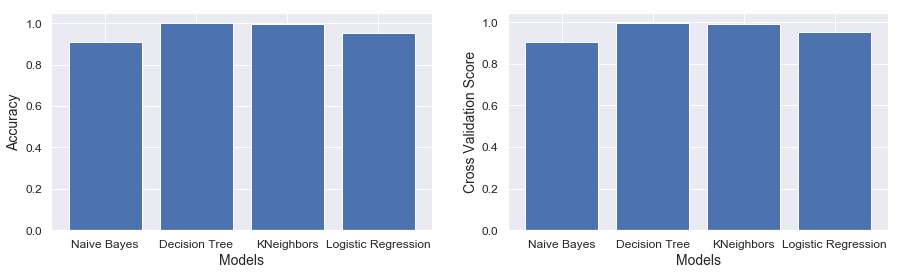

In [151]:
plt.figure(figsize=[15,4])
print("Accuracy is :", acc)
print("cross validation score:", cross_score)
plt.subplot(121)
models = ['Naive Bayes','Decision Tree', 'KNeighbors', 'Logistic Regression']
plt.bar(models,acc)
plt.xlabel("Models")
plt.ylabel("Accuracy")

plt.subplot(122)
models = ['Naive Bayes','Decision Tree', 'KNeighbors', 'Logistic Regression']
plt.bar(models,cross_score)
plt.xlabel("Models")
plt.ylabel("Cross Validation Score")


plt.show()

In [152]:
#deep neural network classifier
def getdnnclf():
    clf = Sequential()
    clf.add(Dense(1024, input_dim = 41, activation = 'relu'))
    clf.add(BatchNormalization())
    clf.add(Dense(1024, activation='relu'))
    clf.add(BatchNormalization())
    clf.add(Dense(512, activation='relu'))
    clf.add(Dense(64, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return clf

In [73]:
attack_classes = ['back', 'buffer_overflow','ftp_write','guess_passwd','imap','ipsweep','land',
                  'loadmodule','multihop','neptune','nmap','normal','perl','phf','pod','portsweep'
                 'rootkit','satan','smurf','spy','teardrop','warezclient','warezmaster']

train_label = pd.DataFrame()
test_label = pd.DataFrame()

for attack_type in attack_classes:
    train_label[attack_type] = train['service'].apply(lambda x : int(x == attack_type))
    test_label[attack_type] = test['service'].apply(lambda x : int(x == attack_type))

In [74]:
# training on DNN classifier

dnn_accuracy = []

for attack_type in attack_classes:
    clf = getdnnclf()
    clf.fit(X_train, train_label[attack_type], batch_size = 1024, epochs = 5, 
            validation_data = (X_test, test_label[attack_type]), verbose = 0)
    y_pred = (clf.predict(X_test) >= 0.5).astype(int)
    stacked_train_df[attack_type]['dnn'] = (clf.predict(X_train) >= 0.5).astype(int)
    stacked_test_df[attack_type]['dnn'] = y_pred
    dnn_accuracy += [accuracy_score(test_label[attack_type], y_pred)]
    
mean_dnn_accuracy = np.mean(dnn_accuracy)
    
print("Deep Neural Network Classifier...")
print("Mean Accuracy score : " + str(mean_dnn_accuracy))

ValueError: Input arrays should have the same number of samples as target arrays. Found 17634 input samples and 25192 target samples.

In [131]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver="lbfgs",hidden_layer_sizes=(5,2))
clf.fit(train_x,train_y)

print("accuracy on train data :",clf.score(train_x,train_y))


('accuracy on train data :', 0.9723721816449666)


In [153]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)
x_train.flag.unique()
#print(x_train.iloc[1,:])
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_test.iloc[0])
print(y_test.iloc[0])

((17634, 41), (17634,), (7558, 41), (7558,))
duration                       -0.113551
src_bytes                      -0.010093
dst_bytes                      -0.039310
land                           -0.008910
wrong_fragment                 -0.091223
urgent                         -0.006301
hot                            -0.091933
num_failed_logins              -0.026220
logged_in                      -0.807626
num_compromised                -0.021873
root_shell                     -0.039377
su_attempted                   -0.027665
num_root                       -0.021724
num_file_creations             -0.027808
num_shells                     -0.018905
num_access_files               -0.043917
num_outbound_cmds               0.000000
is_host_login                   0.000000
is_guest_login                 -0.095990
count                           0.256462
srv_count                      -0.106238
serror_rate                     1.595477
srv_serror_rate                 1.600209
rerror_rate 

In [154]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver="lbfgs",activation = "logistic",hidden_layer_sizes=(5,2))
clf1 = MLPClassifier(solver="sgd",activation = "tanh",hidden_layer_sizes=(5,2))
clf2 = MLPClassifier(solver="adam",activation = "relu", hidden_layer_sizes=(5,2))

clf.fit(x_train,y_train)
clf1.fit(x_train,y_train)
clf2.fit(x_train,y_train)
print("accuracy on train data with lbfgs and logistic activation:",clf.score(x_train,y_train))
print("accuracy on train data with sgd and tanh activation:",clf1.score(x_train,y_train))
print("accuracy on train data with adam and relu activation:",clf2.score(x_train,y_train))

('accuracy on train data with lbfgs and logistic activation:', 0.9735737779290008)
('accuracy on train data with sgd and tanh activation:', 0.9753884541227175)
('accuracy on train data with adam and relu activation:', 0.9749347850742883)


In [155]:
y= x_test.iloc[0]
print(y)
single_test =y.values.reshape(1,-1)
predictions = clf.predict(single_test)
print(predictions)
predictions1 = clf1.predict(x_test)
predictions2 = clf2.predict(x_test)

duration                       -0.113551
src_bytes                      -0.010093
dst_bytes                      -0.039310
land                           -0.008910
wrong_fragment                 -0.091223
urgent                         -0.006301
hot                            -0.091933
num_failed_logins              -0.026220
logged_in                      -0.807626
num_compromised                -0.021873
root_shell                     -0.039377
su_attempted                   -0.027665
num_root                       -0.021724
num_file_creations             -0.027808
num_shells                     -0.018905
num_access_files               -0.043917
num_outbound_cmds               0.000000
is_host_login                   0.000000
is_guest_login                 -0.095990
count                           0.256462
srv_count                      -0.106238
serror_rate                     1.595477
srv_serror_rate                 1.600209
rerror_rate                    -0.372186
srv_rerror_rate 

In [79]:
from sklearn.metrics import classification_report,confusion_matrix
print("lbfgs classifier and logistic activation:")
print(confusion_matrix(y_test,predictions))
print("sgd and tanh activation:")
print(confusion_matrix(y_test,predictions1))
print("adam and relu activation:")
print(confusion_matrix(y_test,predictions2))

lbfgs classifier and logistic activation:


ValueError: Found input variables with inconsistent numbers of samples: [7558, 1]

In [16]:
print("lbfgs and logistic:")
print(classification_report(y_test,predictions))
print("sgd and tanh:")
print(classification_report(y_test,predictions1))
print("adam and relu:")
print(classification_report(y_test,predictions2))

lbfgs and logistic:
              precision    recall  f1-score   support

     anomaly       0.99      0.88      0.93      3498
      normal       0.90      0.99      0.95      4060

   micro avg       0.94      0.94      0.94      7558
   macro avg       0.95      0.93      0.94      7558
weighted avg       0.94      0.94      0.94      7558

sgd and tanh:
              precision    recall  f1-score   support

     anomaly       0.99      0.96      0.97      3498
      normal       0.97      0.99      0.98      4060

   micro avg       0.98      0.98      0.98      7558
   macro avg       0.98      0.97      0.98      7558
weighted avg       0.98      0.98      0.98      7558

adam and relu:
              precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      3498
      normal       0.99      0.99      0.99      4060

   micro avg       0.99      0.99      0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99  

In [103]:
x1_train,x1_test,y1_train,y1_test = train_test_split(train.iloc[:,:41],train.iloc[:,41:], train_size=0.70, random_state=2)

In [112]:
x1_test.iloc[0]

duration                             0
protocol_type                      tcp
service                        private
flag                                S0
src_bytes                            0
dst_bytes                            0
land                                 0
wrong_fragment                       0
urgent                               0
hot                                  0
num_failed_logins                    0
logged_in                            0
num_compromised                      0
root_shell                           0
su_attempted                         0
num_root                             0
num_file_creations                   0
num_shells                           0
num_access_files                     0
num_outbound_cmds                    0
is_host_login                        0
is_guest_login                       0
count                              114
srv_count                           20
serror_rate                          1
srv_serror_rate          